In [124]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

In [125]:
# Load the dataset
data = pd.read_csv("df_train.csv")
data['path'] = 'data/' + data['path']
X = data['path']
y = data[['CD79B', 'MAP2K3', 'IMPDH1', 'SLC16A3', 'MPZL3', 'APOBR']]

In [126]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=['path'])
X_test = pd.DataFrame(X_test, columns=['path'])

X_train = pd.concat([X_train, y_train], axis=1)
X_test = pd.concat([X_test, y_test], axis=1)

In [134]:
# Create data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    dtype='float32',
    preprocessing_function=None,
    data_format=None)

In [135]:
# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=None,
    x_col="path",
    y_col=['CD79B', 'MAP2K3', 'IMPDH1', 'SLC16A3', 'MPZL3', 'APOBR'],
    class_mode="raw",
    target_size=(224, 224),
    batch_size=32
)

# Create a generator for the validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=None,
    x_col="path",
    y_col=['CD79B', 'MAP2K3', 'IMPDH1', 'SLC16A3', 'MPZL3', 'APOBR'],
    class_mode="raw",
    target_size=(224, 224),
    batch_size=32
)

Found 79 validated image filenames.
Found 20 validated image filenames.


In [136]:
# Create the base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='linear')(x)

In [137]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [138]:
# Fit the model on the training data
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=val_generator)

C:\Users\sathy\AppData\Local\Temp\ipykernel_21580\672171457.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
2/2 [==============================] - 2s 953ms/step - loss: 7539.9307 - accuracy: 0.1489 - val_loss: 5752.8159 - val_accuracy: 0.1000
Epoch 2/100
2/2 [==============================] - 1s 500ms/step - loss: 6348.0718 - accuracy: 0.3404 - val_loss: 4612.7295 - val_accuracy: 0.1000
Epoch 3/100
2/2 [==============================] - 1s 359ms/step - loss: 4958.7690 - accuracy: 0.2979 - val_loss: 3390.4980 - val_accuracy: 0.1000
Epoch 4/100
2/2 [==============================] - 1s 500ms/step - loss: 3724.1460 - accuracy: 0.2969 - val_loss: 2385.6433 - val_accuracy: 0.1000
Epoch 5/100
2/2 [==============================] - 1s 532ms/step - loss: 2073.3142 - accuracy: 0.2766 - val_loss: 1509.1223 - val_accuracy: 0.1500
Epoch 6/100
2/2 [==============================] - 1s 625ms/step - loss: 1730.8254 - accuracy: 0.2553 - val_loss: 1028.4661 - val_accuracy: 0.1000
Epoch 7/100
2/2 [==============================] - 1s 641ms/step - loss: 902.4200 - accuracy: 0.3404 - val_loss: 936.7

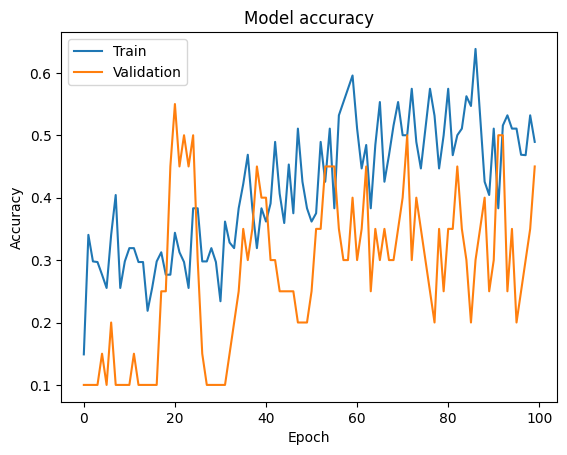

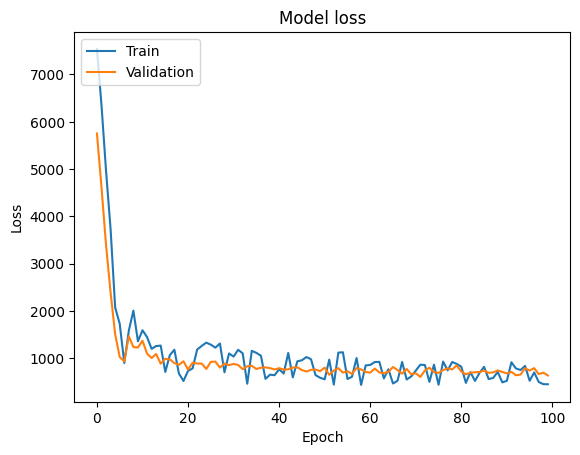

In [139]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [141]:
#calculate r^2
from sklearn.metrics import r2_score
y_pred = model.predict_generator(val_generator)
r2_score(y_test, y_pred)

C:\Users\sathy\AppData\Local\Temp\ipykernel_21580\502921173.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(val_generator)


-0.278157140429544